# Intel Image Classification Project

### by [Daniel and Souleimane]

# Introduction

Welcome to the Intel Image Classification Project!

In this project, we will explore the Intel Image Classification dataset, uncover patterns in nature, and build powerful machine learning models to classify images.

# Importing Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import ssl
ssl._create_default_https_context = ssl._create_unverified_context


# Load data and define categories

In [2]:
categories = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

train_dir = 'seg_train/'
test_dir = 'seg_test/'
prediction_dir = 'seg_pred/'

# Load filenames and labels

In [3]:
train_filenames = []
train_labels = []
for category, label in categories.items():
    category_dir = os.path.join(train_dir, category)
    for filename in os.listdir(category_dir):
        train_filenames.append(os.path.join(category_dir, filename))
        train_labels.append(label)

test_filenames = []
test_labels = []
for category, label in categories.items():
    category_dir = os.path.join(test_dir, category)
    for filename in os.listdir(category_dir):
        test_filenames.append(os.path.join(category_dir, filename))
        test_labels.append(label)

# Create DataFrame

In [4]:
train_df = pd.DataFrame({'filename': train_filenames, 'label': train_labels})
test_df = pd.DataFrame({'filename': test_filenames, 'label': test_labels})

# Data Analysis
The dataset contains over 25.000 images, segmented into six different categories.

Each image is 150x150 pixels large, they are colorized and each pixel is made up of three channels.

### Category distribution

In [5]:
from collections import Counter

print(Counter(train_labels))
print(Counter(test_labels))

Counter({3: 2512, 2: 2404, 5: 2382, 4: 2274, 1: 2271, 0: 2191})
Counter({2: 553, 3: 525, 4: 510, 5: 501, 1: 474, 0: 437})


There is a slight imbalance, where the availability of images of the categories 0 and 1 is slightly smaller than for the rest. However, this is not to a degree where some sort of over- or undersampling would meaningfully improve performance

### Visualization

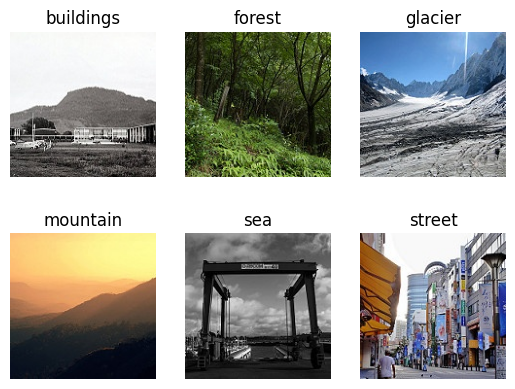

In [6]:
import matplotlib.pyplot as plt

sample_images = []
for category in categories.keys():
    category_dir = os.path.join(train_dir, category)
    first_image = os.listdir(category_dir)[0]
    sample_images.append(os.path.join(category_dir, first_image))

for i, img_path in enumerate(sample_images):
    img = plt.imread(img_path)
    plt.subplot(2, 3, i+1)
    plt.imshow(img)
    plt.title(os.path.basename(os.path.dirname(img_path)))
    plt.axis('off')
plt.show()


# Splitting the data

In [7]:
train_df, val_df = train_test_split(train_df, test_size=0.2, stratify=train_df['label'], random_state=42)

# Data augmentation

In [8]:
train_datagen = ImageDataGenerator(rescale=1.0/255.0,
                                   rotation_range=20,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1.0/255.0)

# Flowing the data

In [9]:
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    x_col='filename',
                                                    y_col='label',
                                                    target_size=(150, 150),
                                                    batch_size=32,
                                                    class_mode='raw')

val_generator = val_datagen.flow_from_dataframe(val_df,
                                                x_col='filename',
                                                y_col='label',
                                                target_size=(150, 150),
                                                batch_size=32,
                                                class_mode='raw')

test_generator = val_datagen.flow_from_dataframe(test_df,
                                                 x_col='filename',
                                                 y_col='label',
                                                 target_size=(150, 150),
                                                 batch_size=32,
                                                 class_mode='raw')

Found 11227 validated image filenames.
Found 2807 validated image filenames.
Found 3000 validated image filenames.


# Models Comparison

Comparing models for image classification

# Model 1: ResNet50

In [11]:
base_model_resnet = ResNet50(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions_resnet = Dense(len(categories), activation='softmax')(x)
model_resnet = Model(inputs=base_model_resnet.input, outputs=predictions_resnet)
model_resnet.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Model 2: VGG16

In [12]:
base_model_vgg = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
predictions_vgg = Dense(len(categories), activation='softmax')(x)
model_vgg = Model(inputs=base_model_vgg.input, outputs=predictions_vgg)
model_vgg.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Train models

In [16]:
history_resnet = model_resnet.fit(train_generator, epochs=1, validation_data=val_generator)

351/351 [==============================] - 949s 3s/step - loss: 0.4979 - accuracy: 0.8256 - val_loss: 1.0223 - val_accuracy: 0.5796


In [17]:
history_vgg = model_vgg.fit(train_generator, epochs=1, validation_data=val_generator)

351/351 [==============================] - 1497s 4s/step - loss: 1.9771 - accuracy: 0.1687 - val_loss: 1.7909 - val_accuracy: 0.1792


# Evaluation

Unfortunately due to unforeseen hardware problems the model can only be trained for a single epoch

In [18]:
test_loss_resnet, test_acc_resnet = model_resnet.evaluate(test_generator)
test_loss_vgg, test_acc_vgg = model_vgg.evaluate(test_generator)
print(f"ResNet50 Test accuracy: {test_acc_resnet:.4f}")
print(f"VGG16 Test accuracy: {test_acc_vgg:.4f}")

94/94 [==============================] - 85s 905ms/step - loss: 1.7905 - accuracy: 0.1750
ResNet50 Test accuracy: 0.5860
VGG16 Test accuracy: 0.1750


After a single epoch, the resnet50 architecture has a significantly higher accuracy than vgg16.

VGG only consists of 16 layers as opposed to the 50 or resnet50, but has more than 5 times as many parameters. It turns out that for this particular image classification task, having more convolutions inside of the network is more beneficial. This is likely because the features that need to be detected are more abstract and require more layers in order to be detected accurately.